In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import sys 
from os import path as pt
import numpy as np
import matplotlib.pyplot as plt
import ot
from tqdm import tqdm
import random

np.random.seed(999)
random.seed(999)

# Old implementation

L:
[[1 0 0]
 [2 4 0]
 [3 2 1]]
A = LL^T:
[[ 1  2  3]
 [ 2 20 14]
 [ 3 14 14]]
M:
[[1 0 0]
 [2 3 0]
 [3 1 2]]
B = MM^T:
[[ 1  2  3]
 [ 2 13  9]
 [ 3  9 14]]


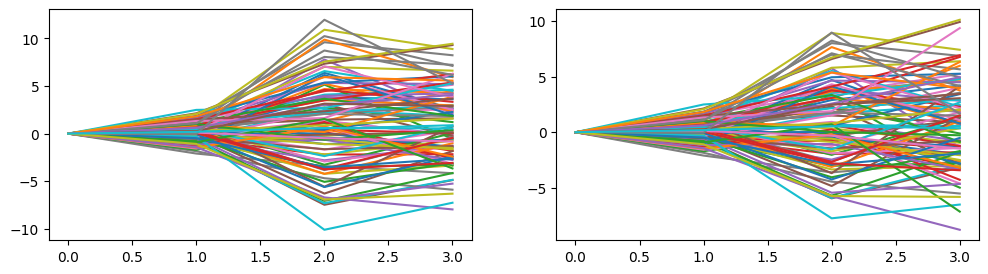

In [2]:
# Non-Markovian
# Initialize samples

T = 4 # The first time is always 0, so the non trivial timestep is T-1 here
n_sample = 500
normalize = False

L0 = np.array([[1, 0, 0], [2, 4, 0], [3, 2, 1]])
A0 = L0 @ L0.T  # A = LL^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T
# np.linalg.cholesky(A) -  L

M0 = np.array([[1, 0, 0], [2, 3, 0], [3, 1, 2]])
B0 = M0 @ M0.T  # A = LL^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T


print('L:')
print(L)
print('A = LL^T:')
print(A)

print('M:')
print(M)
print('B = MM^T:')
print(B)

noise1 = np.random.normal(size=[T-1, n_sample])  # (dim, n_sample)
noise2 = np.random.normal(size=[T-1, n_sample])  # (dim, n_sample)
X = L @ noise1  # (dim, n_sample)
Y = M @ noise1 # (dim, n_sample)
X = np.concatenate([np.zeros_like(X[:1]), X], axis=0)
Y = np.concatenate([np.zeros_like(Y[:1]), Y], axis=0)

fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(X[:,:100])
ax[1].plot(Y[:,:100])
plt.show()

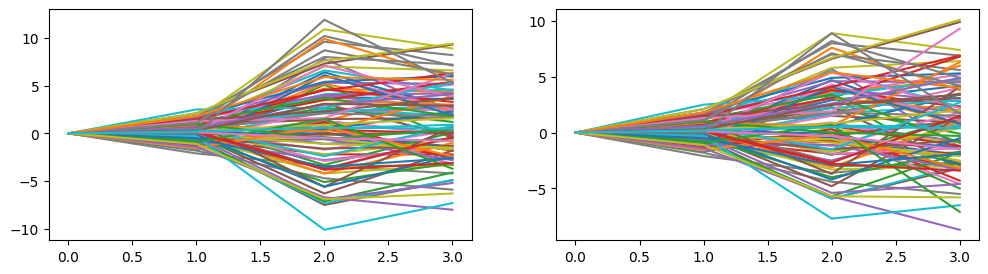

In [3]:
# Grid projection of k-mean projection
def adapted_empirical_measure(samples, delta_n):
    grid_func = lambda x: np.floor(x / delta_n + 0.5) * delta_n
    adapted_samples = grid_func(samples)
    return adapted_samples

adaptedX = adapted_empirical_measure(X, delta_n = 0.1)
adaptedY = adapted_empirical_measure(Y, delta_n = 0.1)

fig, ax = plt.subplots(1,2, figsize=[12,3])
ax[0].plot(adaptedX[:,:100])
ax[1].plot(adaptedY[:,:100])
plt.show()

In [4]:
# # Quantization 
# # Here I use union of both X and Y samples grid for simplicity.
# q2v = np.unique(np.concatenate([adaptedX,adaptedY],axis = 0))  # Quantization to Value
# v2q = {k: v for v, k in enumerate(q2v)} # Value to Quantization
# print('Number of distint values: ', len(q2v))

In [5]:
# from collections import defaultdict

# def path2cm(adaptedpath, v2q, markovian = False):
#     r'''
#     Path to Conditional Measure
#     '''
#     mu_x = [defaultdict(dict) for t in range(T-1)]
#     for path in adaptedpath.T:
#         for t in range(T-1):
#             if markovian:
#                 pre_path = v2q[path[t]]
#             else:
#                 pre_path = tuple(v2q[v] for v in path[:t+1])   # 
#             next_val = v2q[path[t+1]]
#             if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
#                 mu_x[t][pre_path][next_val] = 1
#             else:
#                 mu_x[t][pre_path][next_val] += 1
#     return mu_x
# mu_x = path2cm(adaptedX, v2q)
# nu_y = path2cm(adaptedY, v2q)

# print('Number of condition subpaths of mu_x')
# for t in range(T-1):
#     print(f'Time {t}: {len(mu_x[t])}')

# print('Number of condition subpaths of nu_y')
# for t in range(T-1):
#     print(f'Time {t}: {len(nu_y[t])}')

In [6]:
# q2v_x = [list(mu_x[t].keys()) for t in range(T-1)]   # quantization to tuple value e.g. q2v_x[2][33] ---> (2,3,4)
# v2q_x = [{k: v for v, k in enumerate(q2v_x[t])} for t in range(T-1)] # tuple value to quantization:  v2q_x[2](2,3,4) ---> 33

# q2v_y = [list(nu_y[t].keys()) for t in range(T-1)]  # quantization to tuple value e.g. q2v_x[2][33] ---> (2,3,4)
# v2q_y = [{k: v for v, k in enumerate(q2v_y[t])} for t in range(T-1)] # tuple value to quantization:  v2q_x[2](2,3,4) ---> 33

In [7]:
# def nested(mu_x, nu_y, square_cost_matrix, markovian = False):
#     T = len(mu_x)
#     if markovian:
#         V = [np.zeros([len(q2v),len(q2v)]) for t in range(T)] # since the condition is a quantization, we can still use the global quantization
#     else:
#         V = [np.zeros([len(q2v_x[t]),len(q2v_x[t])]) for t in range(T)] # the condition is a quantization tuple e.g. (3,5,6), and the length of tuple is different at each time, so we use different quantization at each time, therefore, use matrices of different size (depending on the quantization at time t) to record the backward DDP values.

#     for t in tqdm(range(T-1,-1,-1)):
#         print(t)
#         for k1,v1 in mu_x[t].items():
#             for k2,v2 in nu_y[t].items():
#                 # list of probability of conditional distribution mu_x
#                 w1 = list(v1.values()) 
#                 w1 = np.array(w1)/sum(w1) 
#                 # list of probability of conditional distribution nu_y
#                 w2 = list(v2.values())
#                 w2 = np.array(w2)/sum(w2)
#                 # list of quantized values of conditional distribution mu_x (nu_y)
#                 q1 = list(v1.keys())
#                 q2 = list(v2.keys())
#                 # square cost of the values indexed by quantized values: |q2v[q1] - q2v[q2]|^2
#                 cost = square_cost_matrix[np.ix_(q1,q2)]

#                 # At T-1: add V[T] = 0, otherwise add the V[t+1] already computed 
#                 if t < T-1:
#                     if markovian:
#                         cost += V[t+1][np.ix_(q1,q2)]
#                     else:
#                         q1s = [v2q_x[t+1][k1+(q,)] for q in v1.keys()]
#                         q2s = [v2q_y[t+1][k2+(q,)] for q in v2.keys()]
#                         cost += V[t+1][np.ix_(q1s,q2s)]

#                 if markovian:
#                     V[t][k1,k2] = ot.emd2(w1, w2, cost)
#                 else:
#                     V[t][v2q_x[t][k1],v2q_y[t][k2]] = ot.emd2(w1, w2, cost)

#     AW_2square = V[0][0,0]
#     if markovian:
#          AW_2square = V[0][k1,k2]
#     return AW_2square

In [8]:
# square_cost_matrix = (q2v[None,:] - q2v[None,:].T)**2
# AW_2square = nested(mu_x, nu_y, square_cost_matrix)

In [9]:
# def adapted_wasserstein_squared(a, A, b, B):
#     # Cholesky decompositions: A = L L^T, B = M M^T
#     L = np.linalg.cholesky(A)
#     M = np.linalg.cholesky(B)
#     # Mean squared difference
#     mean_diff = np.sum((a - b) ** 2)
#     # Trace terms
#     trace_sum = np.trace(A) + np.trace(B)
#     # L1 norm of diagonal elements of L^T M
#     l1_diag = np.sum(np.abs(np.diag(L.T @ M)))
#     # Final adapted Wasserstein squared distance
#     return mean_diff + trace_sum - 2 * l1_diag

# a, b  = np.zeros([3]), np.zeros([3])
# dist_bench = adapted_wasserstein_squared(a,A,b,B)
# print('Theoretical AW_2^2: ', dist_bench)
# print('Numerical AW_2^2: ', AW_2square)

# New implementation

In [10]:
from utils import quantization
from utils import nested as nst
from utils import adapted_wasserstein_squared as aws
q2v, _, mu_x, nu_y, _, v2q_x, _, v2q_y = quantization(adaptedX, adaptedY, markovian=False)
AW_2square = nst(mu_x, nu_y, v2q_x, v2q_y, q2v, markovian=False)
dist_bench = aws(A, B)
print("Theoretical AW_2^2: ", dist_bench)
print("Numerical AW_2^2: ", AW_2square)

Number of distint values in global quantization:  210
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 55
Time 2: 473
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 55
Time 2: 468


100%|██████████| 3/3 [00:15<00:00,  5.03s/it]

Theoretical AW_2^2:  3.0
Numerical AW_2^2:  3.6557466666666674
